# Titanic Disaster Survival Prediction

Importing required libraries

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Creating training and test datasets

In [2]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

We will make a copy of these datasets so we can work on the copies for EDA.

In [3]:
training_working = training.copy()
test_working = test.copy()

In [4]:
training_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The attribute **Cabin** has more than 50% null values in both test and training datasets. We will therefore remove this attribute rather than handle it. We will also remove the **PassengerId, Ticket** and the **Name** attributes since they are not relevant for our analysis.

In [6]:
def dropNAs(df, attributes):
    return df.drop(attributes, axis = 1)

In [7]:
training_working = dropNAs(training_working, ['PassengerId', 'Name', 'Cabin', 'Ticket'])
test_working = dropNAs(test_working, ['PassengerId', 'Name', 'Cabin', 'Ticket'])

We will further explore the data to find which attributes are most strongly related to survival of a passenger.

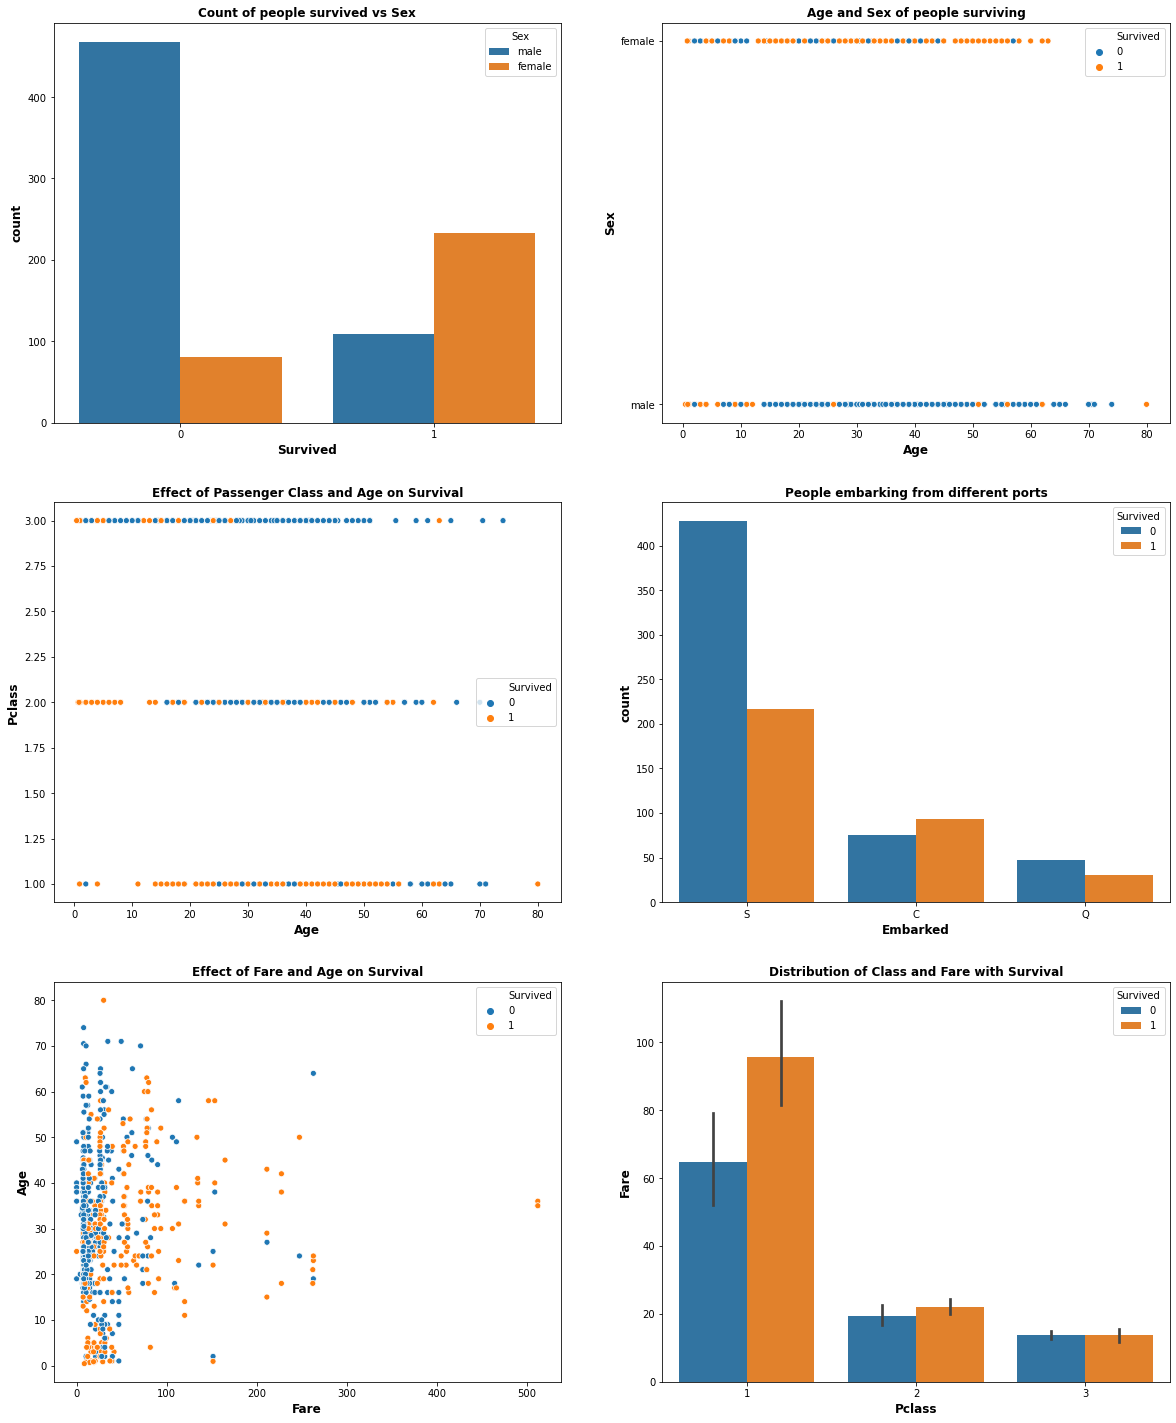

In [8]:
fig, axes = plt.subplots(3, 2, figsize = (20, 25))
axes[0, 0].set_title('Count of people survived vs Sex', fontsize = 12, fontweight = 'semibold')
axes[0, 0].set_ylabel('Count', fontsize = 12, fontweight = 'semibold')
axes[0, 0].set_xlabel('Survived', fontsize = 12, fontweight = 'semibold')
sns.countplot('Survived', data = training_working, hue='Sex', ax = axes[0, 0])
axes[0, 1].set_title('Age and Sex of people surviving', fontsize = 12, fontweight = 'semibold')
axes[0, 1].set_ylabel('Sex', fontsize = 12, fontweight = 'semibold')
axes[0, 1].set_xlabel('Age', fontsize = 12, fontweight = 'semibold')
sns.scatterplot('Age', 'Sex', data = training_working, hue = 'Survived', ax = axes[0, 1])
axes[1, 0].set_title('Effect of Passenger Class and Age on Survival', fontsize = 12, fontweight = 'semibold')
axes[1, 0].set_xlabel('Age', fontsize = 12, fontweight = 'semibold')
axes[1, 0].set_ylabel('Passenger Class', fontsize = 12, fontweight = 'semibold')
sns.scatterplot('Age', 'Pclass', data = training_working, hue = 'Survived', ax = axes[1, 0])
axes[1, 1].set_title('People embarking from different ports', fontsize = 12, fontweight = 'semibold')
axes[1, 1].set_xlabel('Port', fontsize = 12, fontweight = 'semibold')
axes[1, 1].set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])
axes[1, 1].set_ylabel('Count', fontsize = 12, fontweight = 'semibold')
sns.countplot('Embarked', data = training_working, hue='Survived', ax = axes[1, 1])
axes[2, 0].set_title('Effect of Fare and Age on Survival', fontsize = 12, fontweight = 'semibold')
axes[2, 0].set_xlabel('Fare', fontsize = 12, fontweight = 'semibold')
axes[2, 0].set_ylabel('Age', fontsize = 12, fontweight = 'semibold')
sns.scatterplot(x = 'Fare', y = 'Age', data = training_working, hue = 'Survived', ax = axes[2, 0])
axes[2, 1].set_title('Distribution of Class and Fare with Survival', fontsize = 12, fontweight = 'semibold')
axes[2, 1].set_xlabel('Passenger Class', fontsize = 12, fontweight = 'semibold')
axes[2, 1].set_ylabel('Fare', fontsize = 12, fontweight = 'semibold')
sns.barplot(x = 'Pclass', y = 'Fare', data = training_working, hue = 'Survived', ax = axes[2, 1]);

We can infer the following from the above analysis:
    <ul>Relatively more number of females survived the disaster.</ul>
    <ul>More females survived the disaster irrespective of the Age. Some males though, of very high age, around 80 did survive.</ul>
    <ul>Passenger Class has a significant role in determining the survival as passengers of class 1 were given preference above other classes.</ul>
    <ul>Passengers of class 1 did have more chances of survival. This is irrespective of their ages.</ul>
    <ul>The port of embarkation also seems to have some influence on the survival rate.</ul>
    <ul>Only a few passengers could afford high fares, but that did mean that they had high chances of survival.</ul>
    

In [9]:
def differentiateColumns(df):
    numericalColumns = list(df.describe())
    categoricColumns = set(df.columns) - set(numericalColumns)
    return numericalColumns, list(categoricColumns)

In [10]:
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='mean')

In [11]:
def fillMissing(df):
    numeric_variables, cat_variables = differentiateColumns(df)
    df_num = df.drop(cat_variables, axis = 1)
    X_num = imputer_num.fit_transform(df_num)
    df_cat = df.drop(numeric_variables, axis = 1)
    X_cat = imputer_cat.fit_transform(df_cat)
    df_num = pd.DataFrame(X_num, columns=df_num.columns, index = df_num.index)
    df_cat = pd.DataFrame(X_cat, columns=df_cat.columns, index = df_cat.index)
    return pd.concat([df_num, df_cat], axis = 1)

In [12]:
training_working.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [13]:
test_working.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [14]:
training_working = fillMissing(training_working)
test_working = fillMissing(test_working)

In [15]:
training_working.isnull().sum()

Survived    0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Embarked    0
dtype: int64

In [16]:
test_working.isnull().sum()

Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Embarked    0
dtype: int64

We will now encode the categorical values. We will use getdummies from pandas to encode values on the combined set of test and training

In [18]:
combined_working = pd.concat([training_working.drop('Survived', axis = 1), test_working], axis = 0)
categoricalFeatures = differentiateColumns(combined_working)[1]
for field in categoricalFeatures:
    encoded_values = pd.get_dummies(combined_working[field], drop_first=True)
    combined_working.drop(field, axis = 1, inplace = True)
    combined_working = pd.concat([combined_working, encoded_values], axis = 1)

In [19]:
combined_working.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3.0,22.0,1.0,0.0,7.2500,1,0,1
1,1.0,38.0,1.0,0.0,71.2833,0,0,0
2,3.0,26.0,0.0,0.0,7.9250,0,0,1
3,1.0,35.0,1.0,0.0,53.1000,0,0,1
4,3.0,35.0,0.0,0.0,8.0500,1,0,1


In [20]:
training_working = combined_working[:891]
test_working = combined_working[891:]

In [21]:
training_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    float64
 1   Age     891 non-null    float64
 2   SibSp   891 non-null    float64
 3   Parch   891 non-null    float64
 4   Fare    891 non-null    float64
 5   male    891 non-null    uint8  
 6   Q       891 non-null    uint8  
 7   S       891 non-null    uint8  
dtypes: float64(5), uint8(3)
memory usage: 44.4 KB


In [22]:
test_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    float64
 1   Age     418 non-null    float64
 2   SibSp   418 non-null    float64
 3   Parch   418 non-null    float64
 4   Fare    418 non-null    float64
 5   male    418 non-null    uint8  
 6   Q       418 non-null    uint8  
 7   S       418 non-null    uint8  
dtypes: float64(5), uint8(3)
memory usage: 20.8 KB


In [23]:
X = training_working
y = training['Survived']

We will now start making predictions using different classification models.

1. Logistic Regression

In [25]:
logReg = LogisticRegression()
logReg.fit(X, y)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
yhat_logReg = logReg.predict(test_working)

In [29]:
pd.concat([test['PassengerId'], pd.Series(yhat_logReg)], axis = 1).to_csv('logReg_submission_17122020.csv')

The above submission scored 0.77 on the leaderboard.

2. DecisionTree Classifier

In [31]:
dTree = DecisionTreeClassifier()
dTree.fit(X, y)

DecisionTreeClassifier()

In [32]:
yhat_dtree = dTree.predict(test_working)

In [34]:
pd.concat([test['PassengerId'], pd.Series(yhat_dtree)], axis = 1).to_csv('dTree_submission_17122020.csv')

The above submission scored 0.72 on the leaderboard which was not an improvement over the LogisticRegression model.

3. K-Nearest Neighbours

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [37]:
yhat_knn = knn.predict(test_working)

In [38]:
pd.concat([test['PassengerId'], pd.Series(yhat_knn)], axis = 1).to_csv('knn_submission_17122020.csv')

The above submission scores 0.62 which is even less than the DecisionTreeClassifier. And is not an improvment on the best score so far.

4. RandomForestClassifier

In [40]:
ranForest = RandomForestClassifier(n_estimators=100)
ranForest.fit(X, y)

RandomForestClassifier()

In [41]:
yhat_ranForest = ranForest.predict(test_working)

In [42]:
pd.concat([test['PassengerId'], pd.Series(yhat_ranForest)], axis = 1).to_csv('ranForest_submission_17122020.csv')

The above submission also did not improve on the best score. It did however beat the best score of DecisionTreeClassifier.

5. Support Vector Classifier

In [44]:
svc = SVC(kernel='rbf')
svc.fit(X, y)

SVC()

In [45]:
yhat_svc = svc.predict(test_working)

In [46]:
pd.concat([test['PassengerId'], pd.Series(yhat_svc)], axis = 1).to_csv('svc_submission_17122020.csv')

The above model also failed to do any better than the current best score of 0.77